# Foosbot Video processor

This processes raw collected video, producing:
* Aligned acceleration data
* Positions of the rods
* Downsampled video frames

In [1]:
!pip install numpy
!pip install imageio
!pip install matplotlib

# Settings

In [1]:
# Settings
data_path  = ".\\..\\Recorder\\FeatureSetBuilder\\Experiments\\experiment4.config"

# Experiment Settings

In [10]:
import xml.etree.ElementTree as ET
from __future__ import print_function
import sys
import os
import csv
import numpy as np
from random import randint
from random import shuffle

from PIL import Image
import imageio
import itertools as it

import cv2

import pprint
pp = pprint.PrettyPrinter(depth=6)

def xml_load_rect(rect):
    return (int(rect.find("X").text), int(rect.find("Y").text), int(rect.find("W").text), int(rect.find("H").text))

def xml_load_rgb(text):
    tokens = text.split(",")
    return (int(tokens[0]), int(tokens[1]), int(tokens[2]))



            
            
# Class for tracking rod position from camera frames     
class Rod():
    def __init__(self, box, name, gap_colour_edge = (22,28,39),  gap_bar_colour_threshold = 70, gap_min_size = 40, gap_bar_width = 5):
        self.box = box
        self.name = name
        self.gap_colour_edge = gap_colour_edge
        self.gap_bar_colour_threshold = gap_bar_colour_threshold
        self.gap_min_size = gap_min_size
        self.gap_bar_width = gap_bar_width
        self.rod_line = None
        self.gap_tracking_size = None
        
        self._last_frame_pos = 0
    
    def _rod_column_is_edge(self, frame, x_range, y_range):
        sum_distance = 0
        count = 0
        for x in x_range:
            for y in y_range:
                distance = np.linalg.norm(frame[y][x]-self.gap_colour_edge)
                sum_distance += distance
                count += 1
        
        if sum_distance != 0 and sum_distance/count < self.gap_bar_colour_threshold:
            return True
        return False
    
    def update_rod_line(self, edges):
        edges = edges[self.box[1]:(self.box[1] + self.box[3]), self.box[0]:(self.box[0] + self.box[2])]
        lines = cv2.HoughLines(edges,1,np.pi/180,200)
        if lines != None:
            for rho,theta in lines[0]:
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a*rho
                y0 = b*rho
                x1 = int(x0 + 1000*(-b))
                y1 = int(y0 + 1000*(a))
                x2 = int(x0 - 1000*(-b))
                y2 = int(y0 - 1000*(a))
                
                # Update the rod line
                self.rod_line = ((x1+self.box[0],y1+self.box[1]),(x2+self.box[0],y2+self.box[1]))
                return True

        # Don't update the rod line. Continue using last tracking tline
        return False
    
    def track_rod_position(self, frame):
        # Searches the box within the rod line for the specified gap, and
        # returns it's resulting position.
        
        max_frame_movement = self.gap_tracking_size/2
        x_left = None
        y_left = None

        # Search for the right-most edge based on the last frame
        #pp.pprint(range(int(min(self._last_frame_pos + max_frame_movement,np.shape(frame)[1])), int(max(self._last_frame_pos - max_frame_movement,0))))
        for x in range(int(min(self._last_frame_pos + max_frame_movement,np.shape(frame)[1])), int(max(self._last_frame_pos - max_frame_movement,0)), -1):
            y_center = round(( float( x - self.rod_line[0][0] ) / float(self.rod_line[1][0] - self.rod_line[0][0]) )
                         * float( self.rod_line[1][1] - self.rod_line[0][1] )) + self.rod_line[0][1]

            if self._rod_column_is_edge(frame, [x], range(y_center-self.gap_bar_width,y_center+self.gap_bar_width)):
                # Match, found our left edge
                x_left = x
                y_left = y_center
                #print("Found left edge close to old edge at x=%i." % x_left)
                break

        if x_left != None:
            # Search right, making sure we have no edge until approx gap
            x_right = None
            x_right_first_empty = False
            for x in range(int(x_left + self.gap_tracking_size - round(self.gap_tracking_size / 10.0)), int(min(x_left + self.gap_tracking_size + round(self.gap_tracking_size / 10.0), np.shape(frame)[1]))):
                y_center = round(( float( x - self.rod_line[0][0] ) / float(self.rod_line[1][0] - self.rod_line[0][0]) )
                         * float( self.rod_line[1][1] - self.rod_line[0][1] )) + self.rod_line[0][1]

                if self._rod_column_is_edge(frame, [x], range(y_center-self.gap_bar_width,y_center+self.gap_bar_width)):
                    # Match, found our right edge
                    x_right = x
                    #print("Found right close to expectation at x=%i." % x_right)
                    break
                else:
                    x_right_first_empty = True

            if x_right != None and x_right_first_empty == True:
                self._last_frame_pos = x_left
                return (x_left, ((x_left, y_left), (x_right, y_center)), True)
            #print("Failed to find right close to expected at x=%i." % (x_left + self.gap_tracking_size))

        # We need to run a raw search for the gap
        last_pos = None
        #print("Raw search for the gap")
        for x in range(0,np.shape(frame)[1]):
            y_center = round(( float( x - self.rod_line[0][0] ) / float(self.rod_line[1][0] - self.rod_line[0][0]) )
                         * float( self.rod_line[1][1] - self.rod_line[0][1] )) + self.rod_line[0][1]

            if self._rod_column_is_edge(frame, [x], range(y_center-self.gap_bar_width,y_center+self.gap_bar_width)):
                #print("Edge found")
                if last_pos != None:
                    new_gap = np.linalg.norm(x-last_pos[0])
                    #gap = np.linalg.norm((x,y_center)-last_pos)
                    if abs(new_gap-self.gap_tracking_size) < self.gap_tracking_size/10.0:
                        # Use this gap position
                        #print("Found the gap at %i" % last_pos[0])
                        self._last_frame_pos = last_pos[0]
                        return (last_pos[0], ((last_pos[0],last_pos[1]), (x,y_center)), True)
                last_pos = np.array([x,y_center])

        # No result. Return last position, no line
        return (self._last_frame_pos, None, False)
    
    def find_gap_size(self, key_frames):
        # Find the longest distance between two black blobs
        # Idea: Yellow players tracks distance between two bumpers
        #       Red players tracks distance between two players
        gaps = []

        for frame in key_frames:
            # Get the pixel on the line, and one row up and one row down
            gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
            edges = cv2.Canny(gray,50,150,apertureSize = 3)

            last_pos = None
            
            if self.update_rod_line(edges):
                # Found the rod line
                for x in range(0,np.shape(frame)[1]):
                    y_center = round(( float( x - self.rod_line[0][0] ) / float(self.rod_line[1][0] - self.rod_line[0][0]) )
                                     * float( self.rod_line[1][1] - self.rod_line[0][1] )) + self.rod_line[0][1]
                    
                    if self._rod_column_is_edge(frame, [x], range(y_center-self.gap_bar_width,y_center+self.gap_bar_width)):
                        if last_pos != None:
                            gap = np.linalg.norm(x-last_pos[0])
                            if gap > self.gap_min_size:
                                gaps.append( round(gap) )
                                #cv2.circle(frame, (x,y_center), 4, (0,255,25))
                                #cv2.circle(frame, tuple(last_pos), 4, (0,255,25))
                        last_pos = np.array([x,y_center])

            #cv2.imshow('image',frame)
            #pp.pprint(gaps)
            #key = cv2.waitKey()

        # Pick the single most common gap size accross the frames
        self.gap_tracking_size = max(set(gaps), key=gaps.count)
        return self.gap_tracking_size
    
    

global refPt
refPt = (0,0)

def click_callback(event, x, y, flags, param):
    global refPt
    if event == cv2.EVENT_LBUTTONDOWN:
        refPt = (x, y)
        cropping = True

class Recording(object):
    def __init__(self, recording_file):
        self.recording_file = recording_file
        self.tree = ET.parse(recording_file)
        self.root = self.tree.getroot()
        base_path = os.path.dirname(recording_file)
        
        # CROP
        self.crop = xml_load_rect(self.root.find("CROP").find("RECT"))
        
        
        # Files
        self.file_avi = os.path.join(base_path, self.root.find("RECORDING").find("AVI").text)
        self.frame_start = int(self.root.find("RECORDING").find("ACCELRATIONFRAMESTART").text)
        self.frame_end = int(self.root.find("RECORDING").find("ENDFRAME").text)
        
        # Rod tracking settings
        rod_tracking_alignment = self.root.find("RODS").find("TRACKING").find("ALIGNMENT").text
        rod_tracking_gap_colour = xml_load_rgb(self.root.find("RODS").find("TRACKING").find("GAP_COLOUR").text)
        rod_tracking_gap_colour_distance = int(self.root.find("RODS").find("TRACKING").find("GAP_COLOUR_DISTANCE").text)
        rod_tracking_gap_min_size = int(self.root.find("RODS").find("TRACKING").find("GAP_MIN_SIZE").text)
        rod_tracking_rod_width = int(self.root.find("RODS").find("TRACKING").find("ROD_WIDTH").text)
        
        # Video file
        self.cap = cv2.VideoCapture(self.file_avi)
        self.num_frames = self.cap.get(cv2.CAP_PROP_FRAME_COUNT)
        self.frame = 0
        self.has_more = False
        
        # Rods
        self.rods = {}
        for rod in self.root.find("RODS").iter("ROD"):
            self.rods[rod.find("NAME").text] = Rod( xml_load_rect(rod.find("RECT")),rod.find("NAME").text, rod_tracking_gap_colour, rod_tracking_gap_colour_distance, rod_tracking_gap_min_size, rod_tracking_rod_width)
    
    def __del__(self):
        self.cap.release()
    
    def process(self):
        # Extract the rod positions
        pass
    
    def initialize(self):
        self._initialize_rod_gaps()
        self.cap.set(1,0)
        self.frame = 0
        self.has_more = True
    
    def get_next_frame(self):
        # Returns:
        # (cropped frame, {rod name = rod positions})
        if( self.cap.isOpened() and self.has_more ):
            ret, frame = self.cap.read()
            if ret==True:
                gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
                edges = cv2.Canny(gray,50,150,apertureSize = 3)

                # Cropped frame
                frame_cropped = frame[self.crop[1]:(self.crop[1]+self.crop[3]), self.crop[0]:(self.crop[0]+self.crop[2])]
                
                # Calculate rod positions
                rod_positions = {}
                for rod_name, rod in self.rods.items():
                    rod_positions[rod_name] = None

                    if self.frame % 120 == 0 or rod.rod_line == None:
                        rod.update_rod_line(edges)

                    failure_count = 0
                    if rod.rod_line != None:
                        (new_x, line, success) = rod.track_rod_position(frame)
                        if( not success ):
                            failure_count += 1
                        rod_positions[rod_name] = new_x

                self.frame += 1
                return (frame_cropped, rod_positions, failure_count)
            else:
                print("frame read failure")
                self.has_more = False
                return (None, None, 0)
        
        return (None, None, 0)
    
    def _initialize_rod_gaps(self):
        print("Loading rod gap tracking sizes...")
        key_frame_count = 30
        #key_frame_count = 5
        small_frame_set = []
        for i in range(key_frame_count):
            frame = i * (self.num_frames/key_frame_count)
            self.cap.set(1,frame)
            ret, frame = self.cap.read()
            small_frame_set.append(frame)
        
        # Load the rod gap sizes to track from a small subset of the frames
        for rod_name, rod in self.rods.items():
            size = rod.find_gap_size(small_frame_set)
            print("\t%s: gap size %i" % (rod_name, size))
    
    def play(self):
        self.initialize()
        
        # Extract the rod positions
        cv2.namedWindow("image")
        
        global refPt
        rod_offence_last_frame_x = 0
        rod_defence_last_frame_x = 0
        rod_goalie_last_frame_x = 0
        self.cap.set(1,3000)
        count = 0
        while(self.cap.isOpened()):
            cv2.setMouseCallback("image", click_callback)
            ret, frame = self.cap.read()
            frame_original = frame.copy()
            gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
            edges = cv2.Canny(gray,50,150,apertureSize = 3)
            
            # Crop region
            box = self.crop
            cv2.rectangle(frame, (box[0], box[1]),
                                (box[0] + box[2], box[1] + box[3]), 
                                (0,255,0) );
            
            # Draw the rods
            for rod_name, rod in self.rods.items():
                box = rod.box
                cv2.rectangle(frame, (box[0], box[1]),
                                    (box[0] + box[2], box[1] + box[3]), 
                                    (255,0,0) );
                
                if count % 120 == 0:
                    rod.update_rod_line(edges)
                
                rod_line = rod.rod_line
                
                if rod_line != None:
                    cv2.line(frame,rod_line[0],rod_line[1],(0,0,255),2)
                    
                    (new_x, line, success) = rod.track_rod_position(frame_original)
                    
                    if line != None:
                        rod_offence_last_frame_x = new_x
                        cv2.line(frame, line[0], line[1], (255,0,255), thickness=4)
            
            
            # Add text
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(frame,'%i,%i: rgb: %i,%i,%i' % (refPt[0],refPt[1],frame[refPt[1]][refPt[0]][0],frame[refPt[1]][refPt[0]][1],frame[refPt[1]][refPt[0]][2]),(10,50), font, 1,(255,255,255),1,cv2.LINE_AA)
            
            cv2.imshow('image',frame)
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
            elif key == ord(' '):
                cv2.waitKey()
                
            count += 1
        
        cv2.destroyAllWindows()
        pass

    
class Chunk():
    def __init__(self, result_folder, chunk_number, size, minimum_length):
        self.chunk_number = chunk_number
        self.result_folder = result_folder
        self.size = size
        self.count = 0
        self.minimum_length = minimum_length
        
        self.frames = []
        self.positions = []
    
    def write(self):
        if self.count > self.minimum_length:
            # Create the output folder
            if not os.path.exists(self.result_folder):
                os.makedir(self.result_folder)
            
            # Create the output chunk
            fourcc = cv2.VideoWriter_fourcc(*'DIVX')
            file_video = os.path.join(self.result_folder, "chunk%i.avi" % self.chunk_number)
            video = cv2.VideoWriter( file_video, fourcc, 30.0, self.size)
            for frame in self.frames:
                video.write(frame)
            video.release()
            
            file_output = os.path.join(self.result_folder, "chunk%i.tsv" % self.chunk_number)
            f_positions = open( file_output, "w")
            f_positions.write("\n".join(self.positions))
            f_positions.close()
            
            return ("chunk%i.avi" % self.chunk_number, "chunk%i.tsv" % self.chunk_number)
        
        return (None, None)
    
    def add_frame(self, frame, positions):
        # Add the frame
        resized_frame = cv2.resize(frame, self.size, interpolation=cv2.INTER_AREA) 
        self.frames.append( resized_frame )
        
        # Add the positions
        self.positions.append("\t".join(positions))
        
        self.count += 1
        

class Experiment(object):
    '''
    Simple class wraps an experiment
    '''

    def __init__(self, experiment_file):
        self.tree = ET.parse(experiment_file)
        self.root = self.tree.getroot()
        self.base_path = os.path.dirname(experiment_file)
        
        # Chunk settings
        self.chunk_min_frames = int(self.root.find("PROCESSING").find("CHUNK_MIN_FRAMES").text)
        self.chunk_rod_failure_limit = int(self.root.find("PROCESSING").find("CHUNK_ROD_FAILURE_LIMIT").text)
        
        # Results
        self.output_columns = self.root.find("OUTPUTS").text.split(",")
        self.output_folder = os.path.join(self.base_path, self.root.find("OUTPUT_FOLDER").text)
        self.output_width = int(self.root.find("PROCESSING").find("VIDEO").find("SIZE").find("W").text)
        self.output_height = int(self.root.find("PROCESSING").find("VIDEO").find("SIZE").find("H").text)
        
        # Recordings
        self.recordings = []
        for recording in self.root.find("RECORDINGS").iter("RECORDING"):
            recording_path = os.path.join(self.base_path, recording.text)
            self.recordings.append( Recording(recording_path) )
        
    def process(self):
        # Process the recordings into continuous valid chunks
        chunk_number = 0
        f_settings = open(os.path.join(self.output_folder, "settings.tsv"), "w")
        f_settings.close()
                
        for recording in self.recordings:
            # Process the chunks from this recording
            print("Processing recording %s into training chunks..." % recording.recording_file)
            chunk = None
            recording.initialize()
            frame_count = 0
            
            chunk_files = []
            chunk_positions_max = [None]*len(self.output_columns)
            chunk_positions_min = [None]*len(self.output_columns)
            
            while recording.has_more:
                (frame, rod_positions, failure_count) = recording.get_next_frame()
                
                
                if chunk != None and !movement_check and !chunk_meets_movement:
                    # Chunk is finished without results
                elif chunk != None and !movement_check and chunk_meets_movement:
                    # Chunk is finished with results  
                elif chunk != None and (failure_count >= self.chunk_rod_failure_limit or frame == None):
                    # We failed to find the necessary number of rods. Chunk is finished.
                    if chunk_meets_movement:
                        print("%i failures at frame %i. Chunk finished." % (failure_count, frame_count))
                        (video_file, position_file) = chunk.write()
                        if video_file != None:
                            chunk_files.append([video_file, position_file])
                    chunk = None
            
                elif chunk == None and failure_count < self.chunk_rod_failure_limit and frame != None:
                    # Start of a new chunk
                    print("Started new chunk %i at frame %i." % (chunk_number, frame_count))
                    chunk = Chunk(self.output_folder, chunk_number, (self.output_width, self.output_height),self.chunk_min_frames)
                    chunk_number += 1
                    
                if chunk != None and frame != None:
                    # Log this chunk
                    positions = []
                    for idx, column in enumerate(self.output_columns):
                        positions.append(str(rod_positions[column]))
                        
                        if float(frame_count) / float(recording.num_frames) > 0.5:
                            if chunk_positions_max[idx] == None:
                                # Use current positions as starting point for max/min value
                                chunk_positions_min[idx] = rod_positions[column]
                                chunk_positions_max[idx] = rod_positions[column]
                            else:
                                # Update these values if the new values is within +- 5 of current max or min
                                if abs(chunk_positions_min[idx] - rod_positions[column]) <= 5:
                                    chunk_positions_min[idx] = min(chunk_positions_min[idx], rod_positions[column])
                                if abs(chunk_positions_max[idx] - rod_positions[column]) <= 5:
                                    chunk_positions_max[idx] = max(chunk_positions_max[idx], rod_positions[column])
                    
                    chunk.add_frame(frame, positions)
                
                if (frame_count % 100) == 0:
                    print("Processed %i of %i frames. On chunk %i in %s." % (frame_count,recording.num_frames,chunk_number-1,recording.recording_file))
                    print("Current min bounds:")
                    pp.pprint(chunk_positions_min)
                    print("Current max bounds:")
                    pp.pprint(chunk_positions_max)
                
                frame_count += 1
            
            # Write the final chunk
            if chunk != None:
                (video_file, position_file) = chunk.write()
                if video_file != None:
                    chunk_files.append([video_file, position_file])
            
            # Write the list of chunks
            f_settings = open(os.path.join(self.output_folder, "settings.tsv"), "a")
            for chunk_file in chunk_files:
                f_settings.write("\t".join(chunk_file))
                for value in chunk_positions_min:
                    f_settings.write("\t%i" % value)
                for value in chunk_positions_max:
                    f_settings.write("\t%i" % value)
                f_settings.write("\n")
            f_settings.close()

print("Opening experimient config frames from path %s." % (data_path))
#rec = Recording("E:\\Repos\\FoosBot\\Recorder\\FeatureSetBuilder\\Experiments\\HOF1\\recording.config")
#rec.play()
#rec.initialize()

exp = Experiment(data_path)
exp.process()

#for i in range(1000):
#    pp.pprint(rec.get_next_frame()[1])



Opening experimient config frames from path .\..\Recorder\FeatureSetBuilder\Experiments\experiment4.config.
Processing recording .\..\Recorder\FeatureSetBuilder\Experiments\.\HOF1\recording.config into training chunks...
Loading rod gap tracking sizes...


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\ipykernel\__main__.py:60: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\ipykernel\__main__.py:162: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


	Rod 3: gap size 247
	Rod 2: gap size 137
	Rod 1: gap size 118


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\ipykernel\__main__.py:129: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\ipykernel\__main__.py:451: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\ipykernel\__main__.py:457: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Started new chunk 0 at frame 0.
Processed 0 of 205794 frames. On chunk 0 in .\..\Recorder\FeatureSetBuilder\Experiments\.\HOF1\recording.config.
Current min bounds:
[None, None, None]
Current max bounds:
[None, None, None]


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\ipykernel\__main__.py:444: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Processed 100 of 205794 frames. On chunk 0 in .\..\Recorder\FeatureSetBuilder\Experiments\.\HOF1\recording.config.
Current min bounds:
[None, None, None]
Current max bounds:
[None, None, None]
Processed 200 of 205794 frames. On chunk 0 in .\..\Recorder\FeatureSetBuilder\Experiments\.\HOF1\recording.config.
Current min bounds:
[None, None, None]
Current max bounds:
[None, None, None]
Processed 300 of 205794 frames. On chunk 0 in .\..\Recorder\FeatureSetBuilder\Experiments\.\HOF1\recording.config.
Current min bounds:
[None, None, None]
Current max bounds:
[None, None, None]
Processed 400 of 205794 frames. On chunk 0 in .\..\Recorder\FeatureSetBuilder\Experiments\.\HOF1\recording.config.
Current min bounds:
[None, None, None]
Current max bounds:
[None, None, None]
Processed 500 of 205794 frames. On chunk 0 in .\..\Recorder\FeatureSetBuilder\Experiments\.\HOF1\recording.config.
Current min bounds:
[None, None, None]
Current max bounds:
[None, None, None]
Processed 600 of 205794 frames. On 

KeyboardInterrupt: 

# Input video

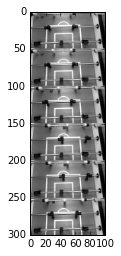

In [3]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

data = np.uint8((video.get_frame(0)+1))
for frame in range(5):
    data = np.concatenate( (data, np.uint8((video.get_frame(frame*10)+1)*128)),0 )

%matplotlib inline
plt.imshow(data,cmap="gray")
plt.show()


# Define our training data class

In [4]:
# Define the reader for both training and evaluation action.
class TrainingData(object):
    def __init__(self, video, accel_file, is_training, validation_rate):
        '''
        Load video file paths and their corresponding labels.
        '''
        self.video = video
        self.accel_file     = accel_file
        self.output = []
        self.sequence_length = 7
        self.width = 100
        self.height = 50
        self.validation_rate = validation_rate
        self.is_training = is_training
        self.validation_rate = validation_rate
        ranges = [200,400,800,1600,3200,6400,12800]


        # Load the accelerometer frames and encode the output as one-hots according to the range
        fh = open(self.accel_file)
        lines = fh.readlines()
        self.output = np.zeros(shape=(len(lines),2), dtype=np.float32)
        i = 0
        for line in lines:
            tokens = line.split('\t')
            self.output[i,0] = max([0.0,min([1.0,float(tokens[1])/8000.0 + 0.5])]) #float(tokens[1])/10000.0 #max([-1.0,min([1.0,float(tokens[1])/1000.0])])
            self.output[i,1] = max([0.0,min([1.0,float(tokens[2])/8000.0 + 0.5])]) #float(tokens[2])/10000.0 #max([-1.0,min([1.0,float(tokens[2])/1000.0])])
            i += 1
        fh.close()

        #self.output = self.output[0:4000,:] #Debug switch to use a very small amount of data
        #self.output = self.output[0:15000] #Debug switch to use a very small amount of data
        self.output_full = self.output
        
        index_validate_start = int(len(self.output)*(1.0-validation_rate))

        # Negative values tell it to flip the frame horizontally. We flip the acceleration output direction correspondingly.
        #self.indices_train = list(range(self.sequence_length,index_validate_start))
        #self.indices_validate = list(range(index_validate_start,len(self.output)))
        self.indices_train = list(range(self.sequence_length,index_validate_start)) + list(range(-index_validate_start+1, -self.sequence_length+1))
        self.indices_validate = list(range(index_validate_start,len(self.output))) + list(range(-len(self.output)+1, -index_validate_start+1))
        self.indices_train_full = self.indices_train
        self.indices_validate_full = self.indices_validate
        
        self.indices_active = []
        self.batch_index =  0

        print("Using %i samples for training, %i samples for validation." % (len(self.indices_train), len(self.indices_validate)))

        # Calculate and print the output distribution for training and validation
        self.sum_output_train = np.sum(self.output[self.sequence_length:index_validate_start],0)
        self.sum_output_validate = np.sum(self.output[index_validate_start:len(self.output)],0)

        print("Output distribution for training data:")
        print(self.sum_output_train)
        print("Output distribution for validation data:")
        print(self.sum_output_validate)

        #pp.pprint(self.unskew_random_indices(self.indices_train, 10))

    def set_size(self, new_size):
        # Test function
        self.output = self.output_full[0:new_size,:]
        index_validate_start = int(len(self.output)*(1.0-self.validation_rate))
        self.indices_train = list(range(self.sequence_length,index_validate_start))
        self.indices_validate = list(range(index_validate_start,len(self.output)))
        

    def size(self):
        return len(self.indices_active)

    def has_more(self):
        if self.batch_index < len(self.indices_active):
            return True
        return False

    def unskew_random_indices(self, indices, num_indices_to_select):
        # Select indices to balance out the possible output values

        # Build the output distributesions
        nbins = 10
        num_outputs = np.size( self.output, 1 )
        distribution = []

        for i in range(num_outputs):
            output = self.output[:,i]
            n, bins = np.histogram(output, nbins, density=False)

            selection_weight = [0] * len(n)
            for i in range(len(n)):
                selection_weight[i] = min([20,1/(n[i]/sum(n))]) # maximum 20-times oversampline

            distribution.append([selection_weight, bins])

        # Build our weighting vector for each index
        probability = [0] * len(indices)
        for n in range(len(indices)):
            max_prob = -10000000
            for i in range(num_outputs):
                best_bin_index, best_bin_value = min(enumerate(distribution[i][1]), key=lambda x: abs(x[1]-self.output[abs(indices[n]),i]))
                best_bin_index = max([0, min([best_bin_index,nbins-1])])
                prob = distribution[i][0][best_bin_index]

                if prob > max_prob and prob > 0:
                    max_prob = prob
            probability[n] = max_prob

        norm_probability = [0] * len(probability)
        for i in range(len(probability)):
            norm_probability[i] = probability[i] / (sum(probability))

        #pp.pprint(norm_probability)
        #print(len(norm_probability))
        #print(len(probability))

        # Draw our sample set
        draw = np.random.choice(indices, num_indices_to_select, p=norm_probability)
        return draw


    def reset(self):
        if self.is_training:
            #self.indices_active = self.unskew_random_indices(list(self.indices_train),len(self.indices_train))
            self.indices_active = self.indices_train
        else:
            self.indices_active = self.indices_validate
        #shuffle(self.indices_active)
        self.batch_index =  0

    def next_minibatch(self, batch_size):
        '''
        Return a mini batch of sequence frames and their corresponding ground truth.
        '''
        batch_indexes = self.indices_active[self.batch_index:self.batch_index+batch_size]
        current_batch_size = len(batch_indexes)
        self.batch_index += batch_size

        if current_batch_size < 0:
            raise Exception('Reach the end of the training data.')

        targets = np.empty(shape=(current_batch_size, 2), dtype=np.float32)
        i = 0
        for index in batch_indexes:
            if index < 0: # indicates the frame is flipped horizontally
                frame_output_linear = -(self.output[-index,0] - 0.5) + 0.5 # flip linear accel
                frame_output_angular = self.output[-index,1]
                targets[i, 0] = frame_output_linear
                targets[i, 1] = frame_output_angular
            else:
                targets[i, 0] = self.output[index,0]
                targets[i, 1] = self.output[index,1]

            i += 1

        #for idx in batch_indexes:
        #    targets[idx - batch_start, :] = self.output[idx]

        # Get the frames for the whole batch in memory
        # [ sequence number, 3 frames, 100 pixels width, 50 pixels height ]
        inputs = self._select_frame_sequences( batch_indexes )

        return inputs, targets, current_batch_size




    def _select_frame_sequences(self, batch_indexes):
        '''
        Select a sequence of frames from video_file and return them as
        a Tensor.
        '''
        #print("building batch %i to %i" % (batch_start, batch_end))

        # Build it into frame sequences
        sequences = np.empty(shape=(len(batch_indexes), 1, self.sequence_length, self.height, self.width), dtype=np.float32)
        count = 0
        for sequence_end in batch_indexes:
            for index in range(0,self.sequence_length):
                if sequence_end < 0: # indicates the frame is flipped horizontally
                    frame = self.video.get_frame(-sequence_end-self.sequence_length+index)[:,:]
                    #data = np.uint8(np.concatenate( ((frame+1)*128, ( np.fliplr(frame)+1)*128 )))
                    #Image.fromarray(data).show()
                    #exit()
                    sequences[count, 0,index,:,:] = np.fliplr(frame)
                else:
                    sequences[count, 0,index,:,:] = self.video.get_frame(sequence_end-self.sequence_length+index)[:,:]
            count += 1

        return sequences


# Prepare our training and testing data

Using 57976 samples for training, 14498 samples for validation.
Output distribution for training data:
[ 14986.59570312  14152.91015625]
Output distribution for validation data:
[ 3747.78735352  3555.97021484]
Using 57976 samples for training, 14498 samples for validation.
Output distribution for training data:
[ 14986.59570312  14152.91015625]
Output distribution for validation data:
[ 3747.78735352  3555.97021484]
Training frame sequences:
(5, 1, 7, 50, 100)
(50, 700)


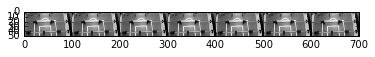

(50, 700)


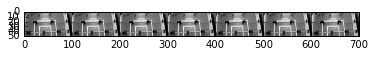

(50, 700)


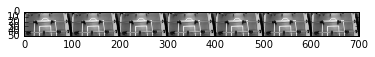

(50, 700)


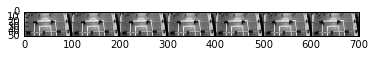

(50, 700)


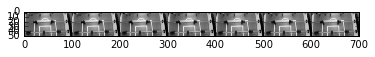

Corresponding Accelerations:


,0,1
0,0.714125,0.436500
1,0.718875,0.224750
2,0.698000,0.172250
3,0.631750,0.285625
4,0.469500,0.366500


In [5]:
import pandas as pd

train_reader = TrainingData(video, os.path.join(data_path, 'train_out.tsv'), is_training=True, validation_rate=0.2)
test_reader = TrainingData(video, os.path.join(data_path, 'train_out.tsv'), is_training=False, validation_rate=0.2)

# Display our train data
num_display = 5
train_reader.reset()
inputs, targets, current_batch_size = train_reader.next_minibatch(num_display)

print("Training frame sequences:")
print(np.shape(inputs))
for i in range(num_display):
    data = np.zeros((train_reader.height,0))
    for n in range(train_reader.sequence_length):
        data = np.concatenate( (data,np.squeeze(inputs[i,0,n,:,:])), axis=1)
    print(np.shape(data))
    plt.imshow(data,cmap="gray")
    plt.show()
    
print("Corresponding Accelerations:")
pd.DataFrame(targets)




First 2000 data recordigns:


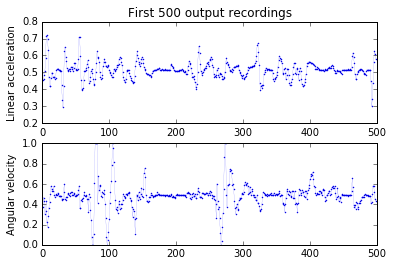

In [6]:
print("First 2000 data recordigns:")
plt.subplot(211)
plt.plot(train_reader.output[1:500,0], marker='.', markersize = 2, linewidth =0.1, markerfacecolor='black')
plt.ylabel("Linear acceleration")
plt.title("First 500 output recordings")
plt.subplot(212)
plt.plot(train_reader.output[1:500,1], marker='.', markersize = 2, linewidth =0.1, markerfacecolor='black')
plt.ylabel("Angular velocity")
plt.show()

# Train our model using CNTK

In [7]:
from keras.models import Sequential
from keras.layers import *


def validate(model, reader, trainer):
    # process minibatches and evaluate the model
    metric_numer    = 0
    metric_denom    = 0
    minibatch_index = 0
    minibatch_size = 1
    
    reader.reset()
    output_true = np.zeros((reader.size(),2))
    output_predicted = np.zeros((reader.size(),2))
    current_output = 0
    
    while reader.has_more():
        videos, labels, current_minibatch = reader.next_minibatch(minibatch_size)
        
        for i in range(minibatch_size):
            output_true[current_output,:] = labels[i,:]
            
            # Use the model to predict the corresponding otuput
            video = np.empty(shape=(1, 1, reader.sequence_length, reader.height, reader.width), dtype=np.float32)
            video[0,0,:,:,:] = videos[i,:,:,:]
            predictions = model.eval({model.arguments[0]:video})
            
            # Log the result
            output_predicted[current_output,:] = predictions
            
            current_output += 1
            
        
        # minibatch data to be trained with
        result = trainer.test_minibatch({input_var : videos, label_var : labels})
        #pp.pprint(result)
        metric_numer += result * current_minibatch
        #print('error rate on an unseen minibatch: {}'.format(metric_numer))
        metric_denom += current_minibatch
        # Keep track of the number of samples processed so far.
        minibatch_index += 1

    print("Validation Results: Minibatch[1-{}]: errs = {:0.2f}% * {}".format(minibatch_index+1, (metric_numer*100.0)/metric_denom, metric_denom))
    plt.subplot(211)
    count = reader.size()
    true, predicted = zip(*sorted(zip(output_true[0:count,0], output_predicted[0:count,0])))
    plt.plot(range(count),true, range(count),predicted )
    plt.ylabel("Linear acceleration")
    plt.title("First 200 output recordings")
    plt.grid(True)
    plt.subplot(212)
    true, predicted = zip(*sorted(zip(output_true[0:count,1], output_predicted[0:count,1])))
    plt.plot(range(count),true, range(count),predicted, marker='.', markersize = 2, linewidth =0.1, markerfacecolor='black')
    plt.ylabel("Angular velocity")
    plt.grid(True)
    plt.show()
    

# Training options
max_epochs = 100

# These values must match for both train and test reader.
image_height       = train_reader.height
image_width        = train_reader.width
sequence_length    = train_reader.sequence_length

# Build the model
model = Sequential([

    Conv3D(32,
           input_shape=(1, sequence_length, image_height, image_width),
           data_format="channels_first",
           kernel_size = (3, 3, 3),
           padding = "same",
           name = "conv1"),
    
    Activation('relu'),
        
    MaxPooling3D( pool_size=(1, 2, 2),
                  padding = "same",
                  data_format="channels_first"),
        
    Conv3D(32,
           data_format="channels_first",
           kernel_size = (3, 3, 3),
           padding = "same",
           name = "conv2"),
    
    Activation('relu'),
        
    MaxPooling3D( pool_size=(1, 2, 2),
                  padding = "same",
                  data_format="channels_first"),
        
    Conv3D(32,
           data_format="channels_first",
           kernel_size = (3, 3, 3),
           padding = "same",
           name = "conv3"),
    
    Activation('relu'),
        
    MaxPooling3D( pool_size=(1, 2, 2),
                  padding = "same",
                  data_format="channels_first"),
        
    Conv3D(32,
           data_format="channels_first",
           kernel_size = (3, 3, 3),
           padding = "same",
           name = "conv4"),
    
    Activation('relu'),
        
    MaxPooling3D( pool_size=(2, 2, 2),
                  padding = "same",
                  data_format="channels_first"),
        
    Flatten(input_shape=(1, sequence_length, image_height, image_width)),
    
    Dense(64),
    Activation('relu'),
    Dropout(0.5),
        
    Dense(64),
    Activation('relu'),
    Dropout(0.5),
    
    Dense(2),
])

'''
model = Sequential([
    Conv3D(32,
           input_shape=(1, sequence_length, image_height, image_width),
           data_format="channels_first",
           kernel_size = (3, 3, 3),
           padding = "same"),
    
    Activation('relu'),
        
    MaxPooling3D( pool_size=(1, 2, 2),
                  padding = "same",
                  data_format="channels_first"),
    
    Dropout(0.5), 
    
    
    
    Conv3D(128,
           data_format="channels_first",
           kernel_size = (1, 3, 3),
           padding = "same"),
    
    Activation('relu'),
    
    MaxPooling3D( pool_size=(1, 2, 2),
                  padding = "same",
                  data_format="channels_first"),
    
    Dropout(0.5),
    
        
        
    Conv3D(32,
           data_format="channels_first",
           kernel_size = (1, 3, 3),
           padding = "same"),
    
    Activation('relu'),
    
    MaxPooling3D( pool_size=(1, 2, 2),
                  padding = "same",
                  data_format="channels_first"),
    
    Dropout(0.5),
        
        
    Conv3D(32,
           data_format="channels_first",
           kernel_size = (1, 3, 3),
           padding = "same"),
    
    Activation('relu'),
    
    MaxPooling3D( pool_size=(2, 2, 2),
                  padding = "same",
                  data_format="channels_first"),
    
    Dropout(0.5),
    
    
        
    Flatten(),
    
    Dense(512),
    Activation('relu'),
    Dropout(0.5),
        
    Dense(64),
    Activation('relu'),
    Dropout(0.5),
    
    Dense(2),
])
'''

# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00003),
              loss='mean_squared_error',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 32, 7, 50, 100)    896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 7, 50, 100)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 32, 7, 25, 50)     0         
_________________________________________________________________
conv2 (Conv3D)               (None, 32, 7, 25, 50)     27680     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 7, 25, 50)     0         
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 32, 7, 13, 25)     0         
_________________________________________________________________
conv3 (Conv3D)               (None, 32, 7, 13, 25)     27680     
__________

In [8]:
# Train the model, iterating on the data in batches of 32 samples
train_reader.reset()
test_reader.reset()
data, labels, current_minibatch = train_reader.next_minibatch(100000000)
#data, labels, current_minibatch = train_reader.next_minibatch(2000)
data_validate, labels_validate, current_minibatch_validate = test_reader.next_minibatch(100000000)
test_reader.reset()
data_validate_short, labels_validate_short, current_minibatch_validate = test_reader.next_minibatch(2000)
#data_validate, labels_validate, current_minibatch_validate = test_reader.next_minibatch(100)

WEIGHTS_FNAME = 'mnist_cnn_weights_%i.hdf'
for epoch in range(100):
    print("------ Epoch %i -------" % epoch)
    model.fit(data, labels, epochs=1, batch_size=32, shuffle=True, validation_data=(data_validate, labels_validate))
    model.save_weights(WEIGHTS_FNAME % epoch)

------ Epoch 0 -------
Train on 57976 samples, validate on 14498 samples
Epoch 1/1
57976/57976 [==============================] - 976s - loss: 0.0615 - acc: 0.5034 - val_loss: 0.0070 - val_acc: 0.5487
------ Epoch 1 -------
Train on 57976 samples, validate on 14498 samples
Epoch 1/1
57976/57976 [==============================] - 961s - loss: 0.0318 - acc: 0.5135 - val_loss: 0.0070 - val_acc: 0.5488
------ Epoch 2 -------
Train on 57976 samples, validate on 14498 samples
Epoch 1/1
57976/57976 [==============================] - 960s - loss: 0.0238 - acc: 0.5226 - val_loss: 0.0054 - val_acc: 0.5491
------ Epoch 3 -------
Train on 57976 samples, validate on 14498 samples
Epoch 1/1
57976/57976 [==============================] - 960s - loss: 0.0208 - acc: 0.5210 - val_loss: 0.0050 - val_acc: 0.5492
------ Epoch 4 -------
Train on 57976 samples, validate on 14498 samples
Epoch 1/1
57976/57976 [==============================] - 960s - loss: 0.0195 - acc: 0.5228 - val_loss: 0.0050 - val_acc: 0.

KeyboardInterrupt: 

In [9]:
epoch = 7
WEIGHTS_FNAME = 'mnist_cnn_weights_%i.hdf'
model.load_weights(WEIGHTS_FNAME % epoch)
print("Loaded model.")

#output_true = labels_validate
#output_predicted = model.predict(data_validate, batch_size=32, verbose=1)
#print("Predicted.")


Loaded model.


2000/2000 [==============================] - 8s     
Predicted.
array([[ 0.55337501,  0.557625  ],
       [ 0.575625  ,  0.71937501],
       [ 0.57950002,  0.78937501],
       ..., 
       [ 0.510625  ,  0.48462501],
       [ 0.520625  ,  0.49149999],
       [ 0.53125   ,  0.4905    ]], dtype=float32)
array([[ 0.49434292,  0.46439332],
       [ 0.49834251,  0.46732718],
       [ 0.50620306,  0.47657374],
       ..., 
       [ 0.49655554,  0.46766964],
       [ 0.49164325,  0.46178874],
       [ 0.49978104,  0.47535259]], dtype=float32)


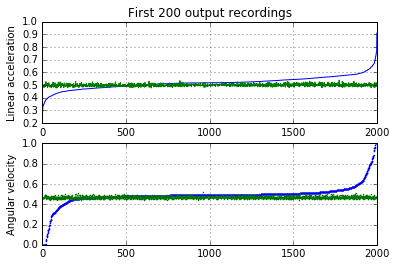

In [18]:
def plot_validate():
    output_true = labels_validate_short
    output_predicted = model.predict(data_validate_short, batch_size=32, verbose=1)
    print("Predicted.")
    
    
    pp.pprint(output_true)
    pp.pprint(output_predicted)
    
    plt.subplot(211)
    count = 2000
    true, predicted = zip(*sorted(zip(output_true[0:count,0], output_predicted[0:count,0])))
    plt.plot(range(count),true, range(count),predicted )
    plt.ylabel("Linear acceleration")
    plt.title("First 200 output recordings")
    plt.grid(True)
    plt.subplot(212)
    true, predicted = zip(*sorted(zip(output_true[0:count,1], output_predicted[0:count,1])))

    plt.plot(range(count),true, range(count),predicted, marker='.', markersize = 2, linewidth =0.1, markerfacecolor='black')
    plt.ylabel("Angular velocity")
    plt.grid(True)
    plt.show()
    
plot_validate()

In [15]:
output_true = labels_validate_short
output_predicted = model.predict(data_validate_short, batch_size=32, verbose=1)
pp.pprint(output_true)
pp.pprint(output_predicted)

2000/2000 [==============================] - 8s     
array([[ 0.55337501,  0.557625  ],
       [ 0.575625  ,  0.71937501],
       [ 0.57950002,  0.78937501],
       ..., 
       [ 0.510625  ,  0.48462501],
       [ 0.520625  ,  0.49149999],
       [ 0.53125   ,  0.4905    ]], dtype=float32)
array([[ 0.49434292,  0.46439332],
       [ 0.49834251,  0.46732718],
       [ 0.50620306,  0.47657374],
       ..., 
       [ 0.49655554,  0.46766964],
       [ 0.49164325,  0.46178874],
       [ 0.49978104,  0.47535259]], dtype=float32)
